<p style="text-align: right">
  <img src="../images/dtlogo.png" alt="Logo" width="200">
</p>

# 💻 🚙 06 - PID: Heading control

A controller outputs commands that can be executed by our robot to achieve a certain goal. For example, in the case of the Duckiebot, the control signals are the linear velocity $v$ and angular velocity $\omega$ of the robot. 

The **P**roportional-**I**ntegral-**D**erivative (PID) controller is an example of a feedback controller where we use an output ($y_t$) of the system to measure tracking errors ($e_t$), that evolve in time, from some reference signal ($r_t$) to alter the control signals ($u_t$), so that the errors are driven to lower values (ideally zero) in time.

<figure>
  <div style="text-align:center;">
  <img src="../images/pid-control/pid-control-diagram.jpg" alt="pid-loop-2" style="width: 300px;"/>
  <figcaption>A PID control loop.</figcaption>
  </div>
</figure>

Consider a Duckiebot driving in the middle of a road with a constant linear velocity. Let's say our goal is to make sure the robot stays in the middle of the lane by adjusting its angular velocity. Intuitively, whenever the robot deviates from the middle of the lane, we will adjust the angular velocity so the robot turns toward the middle of the lane. The question is: by how much?

The name proportional-integral-derivative comes from the fact that the controller adjusts the control signals proportionally to the error at every time instant, while also considers the integral of the error over time (i.e., the accumulation, or sum, of error over time), and the derivative of the error at each time step (i.e., the rate of change of the error over time). The control command is calculated by considering the combination of these three components:

$$ u_t = k_p e(t) + k_i \int_0^t e(\tau) d \tau + k_d \frac{d e_t}{dt},$$

where $k_p$, $k_i$, and $k_d$ denote the proportional, integral, and derivative coefficients of the controller, respectively. 

The PID control problem is to determine values for these parameters (e.g., via trial and error) until the closed loop system performs reasonably well. Typically (but it depends strongly on the complexity of the system):

- Increasing $k_p$ will decrease the the time it takes for the system to approach the reference point (i.e., rise time), but at the risk of overshooting. 
- Increasing $k_d$ will help to decrease this overshooting by preventing the robot from moving too quickly in a direction that increases the error. 
- Increasing $k_i$ will help us to eliminate the steady-state error (i.e., the remaining error that we have when the system has converged), and compensate for unexpected external stimuli during operation.

For example, we can start by only adjusting $k_p$ while keeping $k_i=0$ and $k_d=0$ until the controller is somewhat able to reach the target. We can then fix $k_p$ at this value, and start adjusting $k_d$. Once we found a good value of $k_d$, that reduces the oscillations without slowing the system response down too much, we can proceed to adjust $k_i$ as needed to mitigate steady state errors.

While the above approach to tune our PID controller may work in practice, there is **no guarantee** that our robot will be stable (e.g., it may oscillate around or even completely diverge from the reference point). 

There are many approaches for designing PID controllers in a formal way and obtaining those guarantees. Talking about them though would require introducing more advanced system modeling methods (e.g., linearization, linear time-invariant systems, state-space representations, transfer functions), as well as analysis methods for dynamic systems (e.g., Bode diagrams, Nyquist plots, root locus) and synthesis techniques (e.g., loop shaping, pole placement), for actually determining the coefficients. There is a vast literature on PID control, and new variations on the theme are published every year although it is already a very established method. A video introduction to control systems can be found online, e.g., in the [Control Systems I](https://video.ethz.ch/lectures/d-mavt/2018/autumn/151-0591-00L/6a74fd84-5047-4639-b640-3ab2e6937e8a.html) course held at ETH Zurich.   

The popularity of PID control is due to the fact, amongst other factors, that these formal methods are not necessary to reach a satisfactory outcome. "Rule of thumb" methods such as the Ziegler-Nichols can help us to tune our PID controller, but trail and error (or, "synthesis by iterations", a. k. a. "tweak until death") works, too!

Let's go ahead and design a PID controller!

## Let's get started!

In this activity we will design a proportional, integrative, derivative (PID) controller to regulate the heading ($\theta_t$) of a Duckiebot, while it is driving at a constant linear speed ($v_0$). 

In reference to the PID control diagram above, we consider the following:

* $r_t = \theta_{ref,t} = \theta_{ref}$: the reference signal is a constant angle, expressed in radians
* $\hat y_t = \hat \theta_t$: the controlled variable is the heading of the Duckiebot. This controller controller will estimate it's heading based on the odometry model deigned in the [odometry activity](../05-Odometry/odometry_activity.ipynb), so make sure you're happy about that before proceeding! 
* $u_t = [v_0, \, \omega]^T$: the output of the controller, and input to the plant, will be two variables. The first will be the linear speed of the robot, which we will assume constant throughout this activity. The variable we will control is the angular rate ($\omega_t = \dot \theta_t = \frac{d \theta_t}{dt})$.

The objective of this activity is to determine the values of $k_p, k_i, k_d$ such that we obtain "good" tracking performances.

**DO NOT CHANGE THE NAME OF THE FUNCTION**

In [40]:
import numpy as np

# Heading control

# v_0=0.15 # TODO: Vincenzo make it tunable online kind of like rosparam set
# theta_ref = 70*np.pi/180 # TODO: Vincenzo make it tunable online kind of like rosparam set


def PIDController(v_0, theta_hat, prev_e, prev_int, delta_t): #add theta_ref as input
    """
    Args:
        delta_phi_right (:double:) delta phi right.
        delta_phi_left (:double:) delta phi left.
        prev_e (:double:) previous error.
        delta_t (:double:) delta time.
    returns:
        u (:double:) control command for omega and v_0 (constant).
        current_e (:double:) current tracking error.
    """
    
    # Constant linear velocity of the robot
    v_0 = 0.5 

    # Reference angle in radians
    theta_ref = 90*np.pi/180 # TODO: Vincenzo make it tunable online kind of like rosparam set
    
    # Tracking error
    e = theta_ref - theta_hat

    # integral of the error
    e_int = prev_int + e*delta_t

    # anti-windup - preventing the integral error from growing too much
    #e_int = max(min(e_int,2),-2)


    # derivative of the error
    e_der = (e - prev_e)/delta_t

    # controller coefficients
    Kp = 1
    Ki = 1
    Kd = 0.3

    # PID controller for omega
    omega = Kp*e + Ki*e_int + Kd*e_der
    
    u = [v_0, omega]
    
    print(f"\n\nDelta time : {delta_t} \nE : {e} \nE int : {e_int} \nPrev e : {prev_e} \nU : {u} \nTheta : {np.rad2deg(theta_hat)} \n")

    
    return u, e, e_int

### Simplest Test

With this unit test you can do a quick test of your controller defined by the coefficients above. You can redefine the kinematic parameters as you wish to play around with various factors. We simulate a case without and with synthetic noise added to the measurements. 

You can find the definition of this test in the [unit_test](./unite_test.py) function. 



Delta time : 0.02 
E : 1.5707963267948966 
E int : 0.031415926535897934 
Prev e : 0 
U : [0.5, 25.164157155254244] 
Theta : 0.0 



Delta time : 0.02 
E : 1.0675131836898117 
E int : 0.05276619020969417 
Prev e : 1.5707963267948966 
U : [0.5, -6.428967772676766] 
Theta : 28.836000000000006 



Delta time : 0.02 
E : 1.196092539143347 
E int : 0.0766880409925611 
Prev e : 1.0675131836898117 
U : [0.5, 3.2014709119389373] 
Theta : 21.468945600000005 



Delta time : 0.02 
E : 1.1320631209045682 
E int : 0.09932930341065246 
Prev e : 1.196092539143347 
U : [0.5, 0.27095115073353804] 
Theta : 25.137561029760004 



Delta time : 0.02 
E : 1.1266440978898975 
E int : 0.12186218536845042 
Prev e : 1.1320631209045682 
U : [0.5, 1.1672209380382879] 
Theta : 25.448048177584894 



Delta time : 0.02 
E : 1.1032996791291318 
E int : 0.14392817895103305 
Prev e : 1.1266440978898975 
U : [0.5, 0.89706157666868] 
Theta : 26.78558484776279 



Delta time : 0.02 
E : 1.085358447595758 
E int : 0.1656

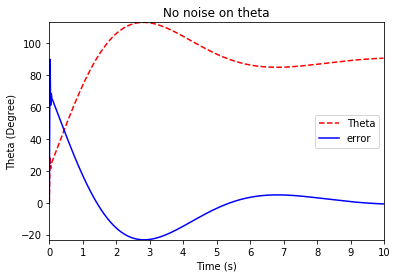

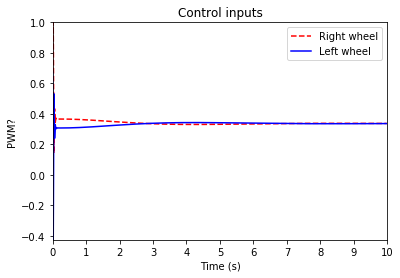



Delta time : 0.02 
E : 1.5572652374332714 
E int : 0.031145304748665427 
Prev e : 0 
U : [0.5, 24.947389103681004] 
Theta : 0.7752743126354937 



Delta time : 0.02 
E : 1.0596418866381627 
E int : 0.05233814248142868 
Prev e : 1.5572652374332714 
U : [0.5, -6.352370232807038] 
Theta : 29.286992100353256 



Delta time : 0.02 
E : 1.1880408592537233 
E int : 0.07609895966650315 
Prev e : 1.0596418866381627 
U : [0.5, 3.1901244081536344] 
Theta : 21.930272875665796 



Delta time : 0.02 
E : 1.0949383675286364 
E int : 0.09799772701707588 
Prev e : 1.1880408592537233 
U : [0.5, -0.2036012813305912] 
Theta : 27.264652713664947 



Delta time : 0.02 
E : 1.0848581645145783 
E int : 0.11969489030736744 
Prev e : 1.0949383675286364 
U : [0.5, 1.0533500096110742] 
Theta : 27.84220580300553 



Delta time : 0.02 
E : 1.0595004226486098 
E int : 0.14088489876033963 
Prev e : 1.0848581645145783 
U : [0.5, 0.8200191934194219] 
Theta : 29.295097389907713 



Delta time : 0.02 
E : 1.08255090548

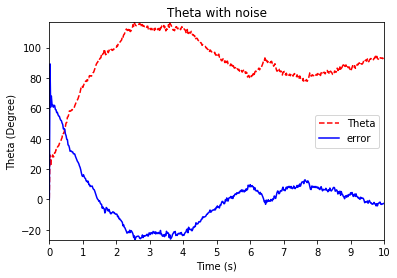

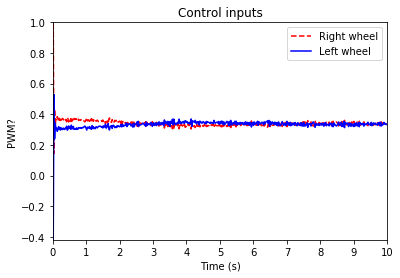

In [41]:
import matplotlib.pyplot as plt

import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
from unit_test import UnitTestHeadingPID

# This is for quick testing purposes only - you can try different values of v_init and R, L or the ones you determined before. Try to change R, L for fun.
v_test = v_0
R_test = 0.033 # m
baseline_test = 0.09 # m
gain_test = 0.6 
trim_test = 0 

# Sanity check (not a faithful representation of the actual behavior, given the motion model is assumed to be exactly known)
unit_test = UnitTestHeadingPID(R_test, baseline_test, v_test, gain_test, trim_test, PIDController) # TODO: Vincenzo - make R, L inputs to this unit testing function
unit_test.test()


### 💻 Test the controller against the simulator




In [ ]:
! cd .. && dts exercises build

### Run the activity on the Duckiebot

**TODO: Vincenzo - write operation manual (how to execute in simulation and on real robot)** 


#### Terminal 1

In the first terminal you have to run the exercises with the standard `dts exercises` command:

In [ ]:
! cd .. && dts exercises test --duckiebot_name ![DB_NAME] 

#### Terminal 2

In this terminal you have to open the `keyboard_control` in order to drive you Duckiebot.


In [ ]:
! dts keyboard_control ![DB_NAME]

#### Terminal 3

In the third terminal you have to attach the container where the  activity is running. 

In [ ]:
! docker -H ![DB_NAME].local exec -it agent /bin/bash